<a href="https://colab.research.google.com/github/Minakshi85/MultiClass-Multilabel/blob/master/Project_1_Multiclass_Multilabel_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from bs4 import BeautifulSoup

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import utils
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D
from keras.layers import Input, Dense, Embedding, LSTM, Activation, Dense, Dropout
from keras.models import Model
from keras.models import Sequential

from nltk import word_tokenize


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
! wget https://www.dropbox.com/s/5721wcs2guuykzl/stacksample.zip?dl=0

--2020-01-09 09:48:14--  https://www.dropbox.com/s/5721wcs2guuykzl/stacksample.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/5721wcs2guuykzl/stacksample.zip [following]
--2020-01-09 09:48:15--  https://www.dropbox.com/s/raw/5721wcs2guuykzl/stacksample.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc0f73fd287d42de1c504ae4c77.dl.dropboxusercontent.com/cd/0/inline/Av0HkOiRIkyyuIAzootcVfZzou0xAA1_UvzyjPjqe6_8qMRTwWgNnO-62yGkkfAi92zsMCHhq9N3gIwHyUjhfk23lzjF0uHF1IH-koULaktWmA/file# [following]
--2020-01-09 09:48:15--  https://ucc0f73fd287d42de1c504ae4c77.dl.dropboxusercontent.com/cd/0/inline/Av0HkOiRIkyyuIAzootcVfZzou0xAA1_UvzyjPjqe6_8qMRTwWgNnO-62yGkkfAi92zsMCHhq9N3gIwHyUjhfk23lzjF0uHF1IH-koULaktWmA/file
Resol

In [3]:
!unzip /content/stacksample.zip?dl=0

Archive:  /content/stacksample.zip?dl=0
  inflating: Answers.csv             
  inflating: Questions.csv           
  inflating: Tags.csv                


In [0]:
tags = pd.read_csv(r'/content/Tags.csv')
ques = pd.read_csv(r'/content/Questions.csv', encoding='latin-1')
ans = pd.read_csv('/content/Answers.csv', encoding='latin-1')

In [5]:
tags.shape, ques.shape, ans.shape

((3750994, 2), (1264216, 7), (2014516, 6))

In [6]:
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [7]:
tags.Id.value_counts()

7752920     5
10853700    5
33857210    5
7154770     5
15498360    5
           ..
31762860    1
2761660     1
19212700    1
11137990    1
8041330     1
Name: Id, Length: 1264216, dtype: int64

In [8]:
ques.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [9]:
ques.Id.value_counts()

36426850    1
25323800    1
21154060    1
13862910    1
25176690    1
           ..
5260450     1
37136770    1
15758500    1
9462950     1
10485760    1
Name: Id, Length: 1264216, dtype: int64

In [10]:
inner = pd.merge(left=ques,right=tags,how='left', left_on='Id', right_on='Id')
print(inner.shape)
inner.head()

(3750994, 8)


,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Tag
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex
1,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,actionscript-3
2,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,air
3,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn
4,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,tortoisesvn


In [11]:
k = inner.Tag.value_counts().nlargest(10) #k = inner.Tag.value_counts().head(10) 
print(k) 

javascript    124155
java          115212
c#            101186
php            98808
android        90659
jquery         78542
python         64601
html           58976
c++            47591
ios            47009
Name: Tag, dtype: int64


In [12]:
tag = k.index
count = k.values
print("Most occurring Tags are :", tag)
print("Counts of the top 10 Tags :", count)

Most occurring Tags are : Index(['javascript', 'java', 'c#', 'php', 'android', 'jquery', 'python',
       'html', 'c++', 'ios'],
      dtype='object')
Counts of the top 10 Tags : [124155 115212 101186  98808  90659  78542  64601  58976  47591  47009]


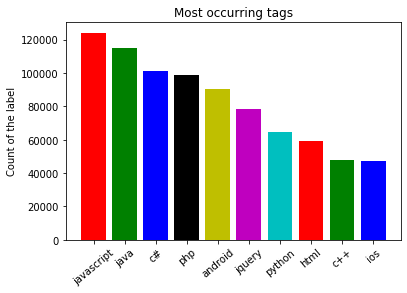

In [13]:
#printing the most occurring tags 
y_pos = np.arange(len(tag))
#print(y_pos)
plt.bar(y_pos, count, color = list('rgbkymc'))
plt.xticks(y_pos, tag, rotation = 40)
plt.ylabel('Count of the label')
plt.title('Most occurring tags')
plt.show()

In [14]:
l1 = ['javascript','java', 'c#','php','android', 'jquery','python','html','c++','ios']
resample = inner[inner['Tag'].isin(l1)]
resample.reset_index(inplace=True)
resample.head()

,index,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Tag
0,14,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c#
1,18,330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,c++
2,28,650,143.0,2008-08-03T11:12:52Z,NaN,79,Automatically update version number,<p>I would like the version property of my app...,c#
3,35,930,245.0,2008-08-04T00:47:25Z,NaN,28,How do I connect to a database and loop over a...,<p>What's the simplest way to connect and quer...,c#
4,39,1010,67.0,2008-08-04T03:59:42Z,NaN,14,"How to get the value of built, encoded ViewState?",<p>I need to grab the base64-encoded represent...,c#


In [15]:
final = resample.drop(['index','Id','OwnerUserId','CreationDate','ClosedDate','Score'],1)
final.head()

,Title,Body,Tag
0,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c#
1,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,c++
2,Automatically update version number,<p>I would like the version property of my app...,c#
3,How do I connect to a database and loop over a...,<p>What's the simplest way to connect and quer...,c#
4,"How to get the value of built, encoded ViewState?",<p>I need to grab the base64-encoded represent...,c#


In [16]:
final['content'] = final['Title']+final['Body']
final.drop(['Title','Body'],1,inplace=True)
print('Shape of the table :', final.shape)
final.head()

Shape of the table : (826739, 2)


,Tag,content
0,c#,Adding scripting functionality to .NET applica...
1,c++,Should I use nested classes in this case?<p>I ...
2,c#,Automatically update version number<p>I would ...
3,c#,How do I connect to a database and loop over a...
4,c#,"How to get the value of built, encoded ViewSta..."


In [17]:
X = final['content']
Y = final['Tag']
X.head()

0    Adding scripting functionality to .NET applica...
1    Should I use nested classes in this case?<p>I ...
2    Automatically update version number<p>I would ...
3    How do I connect to a database and loop over a...
4    How to get the value of built, encoded ViewSta...
Name: content, dtype: object

**Preprocessing of text by removing html tags single characters etc.**

In [0]:
# removing HTML tags 
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [0]:
X_new = []
for i in X:
   X_new.append(remove_tags(i))

In [20]:
X1 = pd.DataFrame(X_new, columns=['content'])
X1.head()

,content
0,Adding scripting functionality to .NET applica...
1,Should I use nested classes in this case?I am ...
2,Automatically update version numberI would lik...
3,How do I connect to a database and loop over a...
4,"How to get the value of built, encoded ViewSta..."


**remove special characters, numbers, punctuations**

In [21]:
X1['refined_text'] = X1['content'].str.replace("[^a-zA-Z]", " ")
X1.head()

,content,refined_text
0,Adding scripting functionality to .NET applica...,Adding scripting functionality to NET applica...
1,Should I use nested classes in this case?I am ...,Should I use nested classes in this case I am ...
2,Automatically update version numberI would lik...,Automatically update version numberI would lik...
3,How do I connect to a database and loop over a...,How do I connect to a database and loop over a...
4,"How to get the value of built, encoded ViewSta...",How to get the value of built encoded ViewSta...


In [22]:
X1.drop(['content'],1,inplace=True)
X1.head()

,refined_text
0,Adding scripting functionality to NET applica...
1,Should I use nested classes in this case I am ...
2,Automatically update version numberI would lik...
3,How do I connect to a database and loop over a...
4,How to get the value of built encoded ViewSta...


**Converting Labels to binary encoded form**

In [23]:
le = LabelEncoder()
Y_label = le.fit_transform(Y)
Y_cat = utils.to_categorical(Y_label)
Y_cat

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X1, Y_cat, test_size = 0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((661391, 1), (661391, 10), (165348, 1), (165348, 10))

In [25]:
x_train.head()

,refined_text
486359,Contentflow how to make caption text to dyna...
155588,Using SendMessage to enter text into an edit c...
110367,Using Multiple Detail Views with Split View Co...
456432,Problems with COM Crystal Report PHP I...
345695,Jcrop button not working in safari or chromeI ...


In [37]:
x_train.dtypes

refined_text    object
dtype: object

In [39]:
import nltk
nltk.download('punkt')  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [43]:
sent_lens=[len(word_tokenize(x)) for x in x_train['refined_text']]
print(max(sent_lens))

6992


In [44]:
print(np.percentile(sent_lens,99))
np.percentile(sent_lens,95)

1138.0


559.0

In [0]:
max_len = 600

**Tokenazation Process**

In [0]:
tok = Tokenizer(lower=True, char_level = False, split=' ', num_words = 5000)
tok.fit_on_texts(x_train['refined_text'])

In [0]:
seq_train = tok.texts_to_sequences(x_train['refined_text'])
seq_test = tok.texts_to_sequences(x_test['refined_text'])

In [52]:
seq_train[10]

[140,
 198,
 942,
 49,
 608,
 1200,
 5,
 3,
 237,
 316,
 2058,
 21,
 105,
 24,
 23,
 608,
 4,
 72,
 5,
 62,
 23,
 140,
 17,
 27,
 118,
 592,
 49,
 3,
 608,
 12,
 3,
 24,
 118,
 1200,
 5,
 237,
 4,
 72,
 5,
 62,
 10,
 316,
 111,
 39,
 37,
 4,
 62,
 11,
 156,
 14,
 294,
 3,
 24,
 16,
 2216,
 7,
 3,
 237,
 17,
 49,
 3,
 608,
 1200,
 5,
 11,
 118,
 592,
 3,
 156,
 27,
 2,
 24,
 16,
 1960,
 1,
 10,
 24,
 21,
 2824,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 24,
 16,
 2216,
 1,
 10,
 7,
 3,
 237,
 17,
 118,
 592,
 3,
 27,
 2,
 24,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,
 2,
 233,
 1,

In [53]:
vocab_size=len(tok.word_index)
vocab_size

1355841

**Parameters setting**

In [0]:
# set parameters:
max_features = 5000
batch_size = 64
embedding_dims = 50
filters = 250
hidden_dims = 250
kernel_size = 3
epochs = 2

In [0]:
seq_train_matrix = pad_sequences(seq_train,maxlen = max_len)
seq_test_matrix = pad_sequences(seq_test,maxlen = max_len)

In [66]:
seq_train_matrix[10]

array([  0,   0,   0, ..., 154, 298, 152], dtype=int32)

**Model Building**

In [0]:
model = Sequential()
model.add(Embedding(max_features+1,
                    embedding_dims,
                    input_length = max_len))
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding = 'valid',
                 activation = 'relu',
                 strides = 1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(10))
model.add(Activation('softmax'))

In [72]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1140, 50)          250050    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1140, 50)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1138, 250)         37750     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 250)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_8 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_7 (Activation)    (None, 250)              

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [74]:
model.fit(seq_train_matrix, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(seq_test_matrix, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 661391 samples, validate on 165348 samples
Epoch 1/2





661391/661391 [==============================] - 162s 245us/step - loss: 0.6460 - acc: 0.7586 - val_loss: 0.5697 - val_acc: 0.7790
Epoch 2/2
661391/661391 [==============================] - 147s 223us/step - loss: 0.5721 - acc: 0.7796 - val_loss: 0.5591 - val_acc: 0.7829
